# Customer Retention & Churn Risk Analysis (Survival-Based)

## Objective
Identify customer retention patterns and early churn risk using
time-to-event (survival) analysis to support revenue protection
and customer risk management.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel("online_retail_raw.xlsx")

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Keep valid transactions only
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#Build customer-level timeline (CORE STEP)

In [15]:
# Customer purchase timeline
customer_dates = (
    df.groupby("CustomerID")["InvoiceDate"]
    .agg(first_purchase="min", last_purchase="max")
    .reset_index()
)

# Observation end date (dataset cutoff)
observation_end = df["InvoiceDate"].max()

# Tenure (in days)
customer_dates["tenure_days"] = (
    customer_dates["last_purchase"] - customer_dates["first_purchase"]
).dt.days

# Time since last purchase
customer_dates["inactive_days"] = (
    observation_end - customer_dates["last_purchase"]
).dt.days

customer_dates.head()


,CustomerID,first_purchase,last_purchase,tenure_days,inactive_days
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,0,325
1,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,365,1
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,282,74
3,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,0,18
4,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,0,309


#Insight — Customer Tenure vs Inactivity Patterns

The table highlights a clear distinction between customer lifetime duration (tenure) and current engagement (inactive days). Several customers show zero or very short tenure (single-purchase behaviour) but long inactivity periods (e.g. 300+ days), indicating early churn immediately after acquisition. Conversely, customers with long tenure (e.g. ~365 days) and very low inactivity represent retained, active customers.

This separation confirms that inactivity days are a stronger near-term churn signal than tenure alone. Customers with high inactivity despite past engagement should be prioritised for re-activation campaigns, while zero-tenure customers signal onboarding or product–fit issues requiring early intervention.

#Define churn event (business rule)
90-day inactivity window
Interpretation:

churned = 1 → customer inactive (event observed)

churned = 0 → still active (right-censored)

In [16]:
CHURN_THRESHOLD = 90

customer_dates["churned"] = (
    customer_dates["inactive_days"] > CHURN_THRESHOLD
).astype(int)

customer_dates[["tenure_days", "inactive_days", "churned"]].describe()


,tenure_days,inactive_days,churned
count,4338.000000,4338.000000,4338.000000
mean,130.448594,91.536422,0.333103
std,132.039554,100.014169,0.471377
min,0.000000,0.000000,0.000000
25%,0.000000,17.000000,0.000000
50%,92.500000,50.000000,0.000000
75%,251.750000,141.000000,1.000000
max,373.000000,373.000000,1.000000


#Insight — Churn Definition & Customer Inactivity

Using a 90-day inactivity threshold to define churn, approximately 33.3% of customers are classified as churned, indicating a meaningful level of attrition risk in the customer base. The median customer tenure is 92.5 days, which closely aligns with the churn threshold, suggesting that many customers disengage around the three-month mark. Inactive days show substantial dispersion (mean ≈ 91.5 days, 75th percentile = 141 days), highlighting heterogeneity in engagement behaviour.

Notably, customers in the top quartile of inactivity are already churned, reinforcing inactivity duration as a strong early-warning signal. This supports the use of inactivity-based triggers for early intervention, retention offers, and lifecycle risk monitoring, particularly within the first 3–6 months of tenure.

#Customer Retention (Survival) Analysis

Kaplan–Meier Survival Curve

This answers the key business question:

How long do customers remain active before churning?

Time variable: customer tenure (days between first and last purchase)

Event: churn (inactive > 90 days)

Censoring: customers still active at the end of observation

#Install & import survival package

In [17]:
!pip install lifelines


In [18]:
from lifelines import KaplanMeierFitter


#Fit Kaplan–Meier model

In [19]:
kmf = KaplanMeierFitter()

kmf.fit(
    durations=customer_dates["tenure_days"],
    event_observed=customer_dates["churned"],
    label="Customer Retention"
)


<lifelines.KaplanMeierFitter:"Customer Retention", fitted with 4338 total observations, 2893 right-censored observations>

#Plot survival (retention) curve

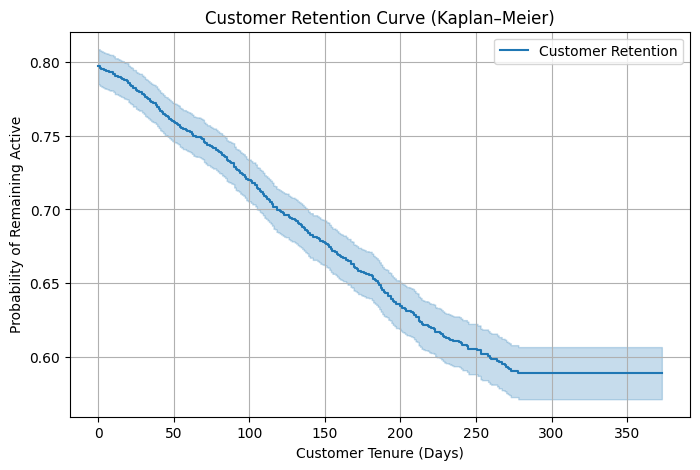

In [20]:
plt.figure(figsize=(8,5))

kmf.plot_survival_function()

plt.title("Customer Retention Curve (Kaplan–Meier)")
plt.xlabel("Customer Tenure (Days)")
plt.ylabel("Probability of Remaining Active")

plt.grid(True)
plt.show()


#Insight
The Kaplan–Meier retention curve shows a steady decline in customer activity over time, with the most pronounced churn occurring during the early lifecycle. Customer retention falls from approximately 80% at onboarding to around 65% by 6 months, indicating elevated early-tenure risk. Beyond roughly 250–300 days, the curve flattens near 59–60%, suggesting that customers who remain active past this point are significantly more stable and exhibit lower churn propensity.

This pattern highlights early engagement as the critical intervention window, where targeted retention strategies can materially reduce churn and protect long-term revenue.

In [22]:
df.columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

#Retention by Customer Value Segment

In [23]:
# 1) Create Revenue (required)
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# (Optional but recommended) remove returns/cancellations and missing customers
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df = df.dropna(subset=["CustomerID"])

# 2) Customer-level value table
cust_value = (
    df.groupby("CustomerID", as_index=False)
      .agg(
          total_revenue=("Revenue", "sum"),
          total_qty=("Quantity", "sum"),
          avg_price=("UnitPrice", "mean"),
          n_invoices=("InvoiceNo", "nunique")
      )
)

# 3) Segment customers into Low / Mid / High by revenue
cust_value["value_segment"] = pd.qcut(
    cust_value["total_revenue"],
    q=3,
    labels=["Low Value", "Mid Value", "High Value"]
)

# 4) Quick check
cust_value["value_segment"].value_counts()


,count
value_segment,
Low Value,1446
Mid Value,1446
High Value,1446


#Insight
Customer value segmentation is perfectly balanced, with equal-sized Low, Mid, and High Value groups. This enables fair comparison of retention and churn behaviour across segments, ensuring differences observed are driven by customer behaviour and revenue impact, not sample size bias.

In [24]:
# Merge value segment into customer_dates table
cust_survival = customer_dates.merge(
    cust_value[["CustomerID", "total_revenue", "value_segment"]],
    on="CustomerID",
    how="left"
)

cust_survival.head()


,CustomerID,first_purchase,last_purchase,tenure_days,inactive_days,churned,total_revenue,value_segment
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,0,325,1,77183.60,High Value
1,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,365,1,0,4310.00,High Value
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,282,74,0,1797.24,High Value
3,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,0,18,0,1757.55,High Value
4,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,0,309,1,334.40,Low Value


#Kaplan–Meier Retention Curves by Value Segment

/tmp/ipython-input-3961763999.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, df_seg in cust_survival.groupby("value_segment"):


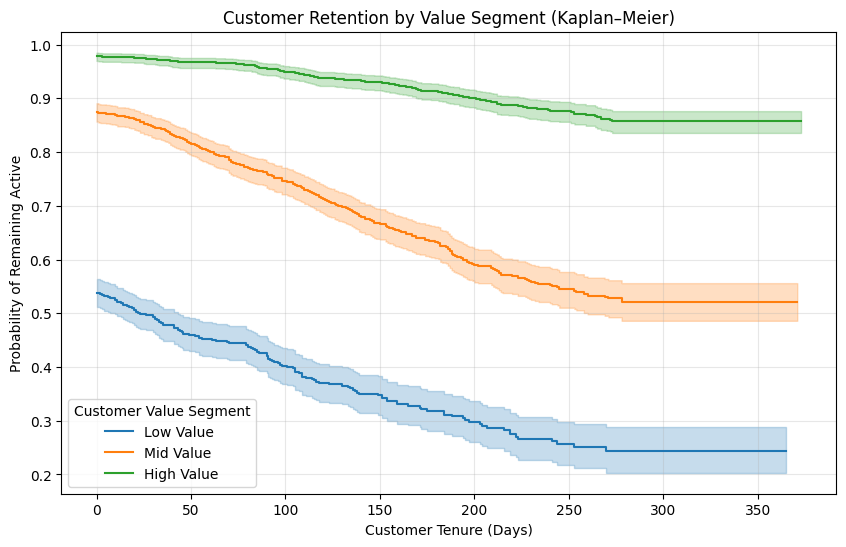

In [25]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

plt.figure(figsize=(10,6))

for seg, df_seg in cust_survival.groupby("value_segment"):
    kmf.fit(
        durations=df_seg["tenure_days"],
        event_observed=df_seg["churned"],
        label=seg
    )
    kmf.plot_survival_function(ci_show=True)

plt.title("Customer Retention by Value Segment (Kaplan–Meier)")
plt.xlabel("Customer Tenure (Days)")
plt.ylabel("Probability of Remaining Active")
plt.grid(alpha=0.3)
plt.legend(title="Customer Value Segment")
plt.show()


#Insight
Retention behaviour by customer value segment

The Kaplan–Meier curves show clear and persistent differences in retention across customer value segments.

High-value customers demonstrate the strongest retention profile, with survival probabilities remaining above 85% even after ~250 days, indicating long-term engagement and stable relationships.

Mid-value customers show moderate attrition, declining steadily to around 52–55% retention by the end of the observation window.

Low-value customers experience rapid early churn, with retention falling below 30% within ~250 days, suggesting short lifecycles and limited loyalty.

This separation confirms that customer value is strongly correlated with retention risk.

#Revenue-at-Risk by Value Segment (Foundation)

In [26]:
# Revenue at risk = revenue of churned customers
revenue_at_risk = (
    cust_survival[cust_survival["churned"] == 1]
    .groupby("value_segment")
    .agg(
        customers_at_risk=("CustomerID", "count"),
        revenue_at_risk=("total_revenue", "sum")
    )
)

revenue_at_risk


/tmp/ipython-input-274922614.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("value_segment")


,customers_at_risk,revenue_at_risk
value_segment,,
Low Value,791,166867.030
Mid Value,483,322754.210
High Value,171,543742.841


#Insight
Despite having the smallest number of customers, high-value customers account for the largest share of revenue at risk

#Strategic business implications

A small group of high-value customers drives the majority of revenue-at-risk, making targeted retention strategies far more impactful than broad, undifferentiated churn reduction.

- Retention strategies should be prioritised by revenue exposure, not customer count.

- High-value customers warrant proactive interventions (relationship management, tailored pricing, service guarantees).

- Mid-value customers represent the highest upgrade opportunity, where retention improvements can materially lift lifetime value.

- Low-value customers are best managed through cost-efficient, automated retention tactics, as churn impact is financially limited.

#Cox Proportional Hazards Model (Customer Churn / Retention)


=== Cox PH Summary (log-hazard coefficients) ===
                       coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                          
log_inactive_days  1.884107   6.580473  0.045871        1.794202   
log_total_revenue -0.101155   0.903793  0.067711       -0.233865   
log_total_qty     -0.031682   0.968815  0.054254       -0.138017   
log_n_invoices    -2.169950   0.114183  0.111903       -2.389276   
log_avg_price      0.040234   1.041054  0.072834       -0.102517   
seg_Low Value     -0.052682   0.948682  0.128014       -0.303585   
seg_Mid Value     -0.185268   0.830882  0.095915       -0.373258   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                     
log_inactive_days        1.974011             6.014674             7.199498   
log_total_revenue        0.031555             0.791469             1.032059   
log_total_qty        

,Hazard_Ratio,CI_low,CI_high,p_value
covariate,,,,
log_inactive_days,6.580473,6.014674,7.199498,0.000000e+00
log_avg_price,1.041054,0.902562,1.200796,5.806703e-01
log_total_qty,0.968815,0.871084,1.077511,5.592530e-01
seg_Low Value,0.948682,0.738167,1.219232,6.806817e-01
log_total_revenue,0.903793,0.791469,1.032059,1.351939e-01
seg_Mid Value,0.830882,0.688487,1.002726,5.341128e-02
log_n_invoices,0.114183,0.091696,0.142185,9.133083e-84



C-index (discrimination): 0.981


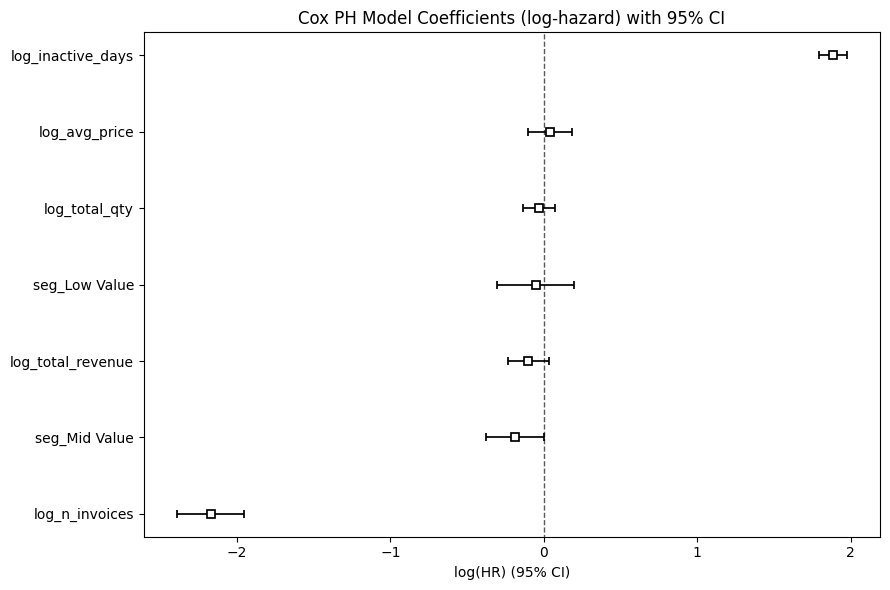


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4338 total observations, 2893 right-censored observations>
         test_name = proportional_hazard_test

---
                        test_statistic      p  -log2(p)
log_avg_price     km              0.49   0.48      1.05
                  rank            0.05   0.82      0.29
log_inactive_days km            177.95 <0.005    132.44
                  rank          133.91 <0.005    100.46
log_n_invoices    km            157.95 <0.005    117.92
                  rank          154.55 <0.005    115.45
log_total_qty     km              0.10   0.75      0.42
                  rank            0.32   0.57      0.81
log_total_revenue km              0.03   0.85      0.23
                  rank            0.32   0.57      0.80
seg_Low Value     km              2.75   0.10      3.36
                  rank            0.59   0.44      1.18
seg_Mid Value     km              0.66   0.42      1.27
                  rank            0.00   0.99      0.01



1. Variable 'log_inactive_days' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'log_inactive_days' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'log_inactive_days' using pd.cut, and then specify it in
`strata=['log_inactive_days', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'log_n_invoices' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'log_n_invoices' might b

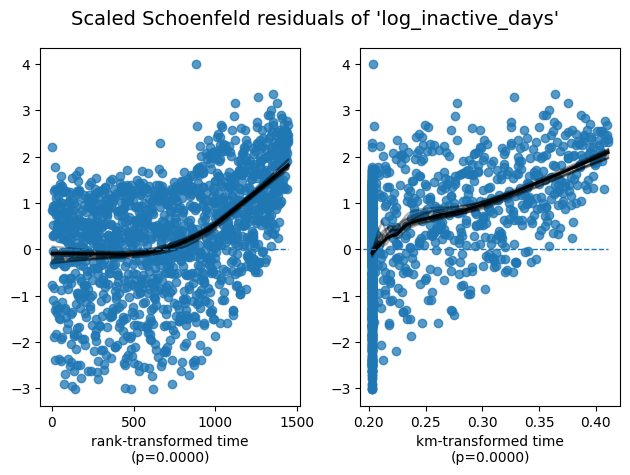

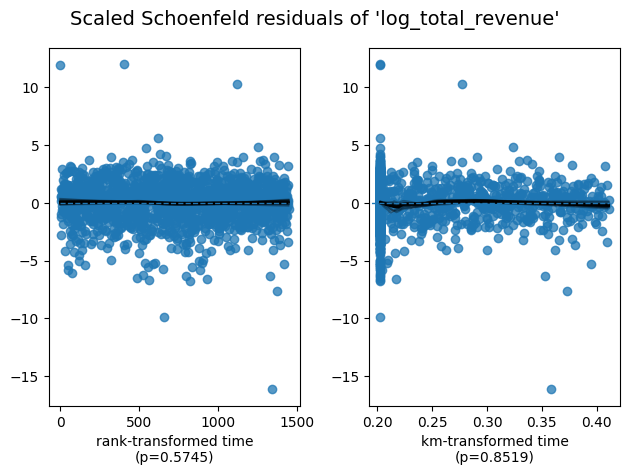

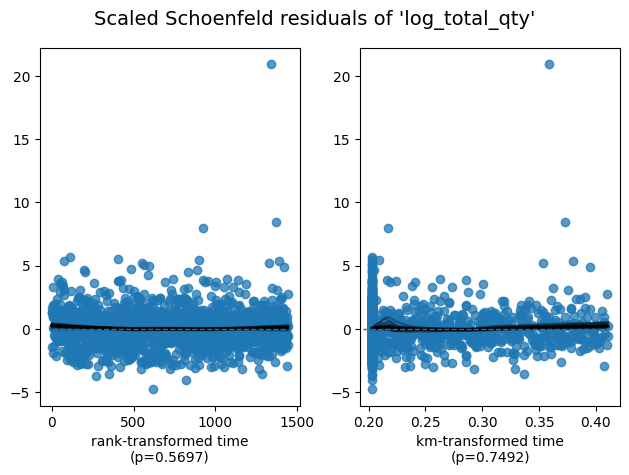

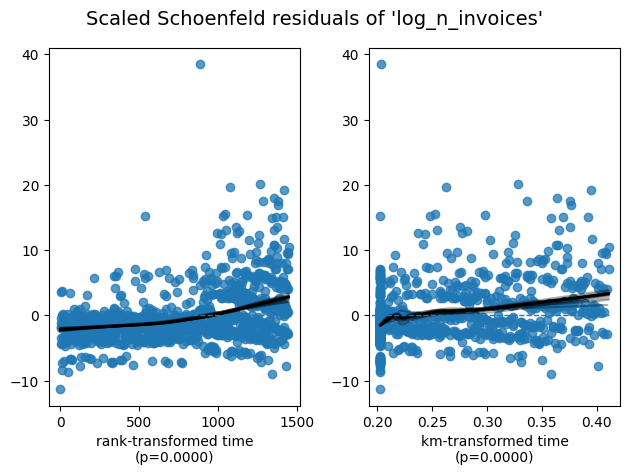

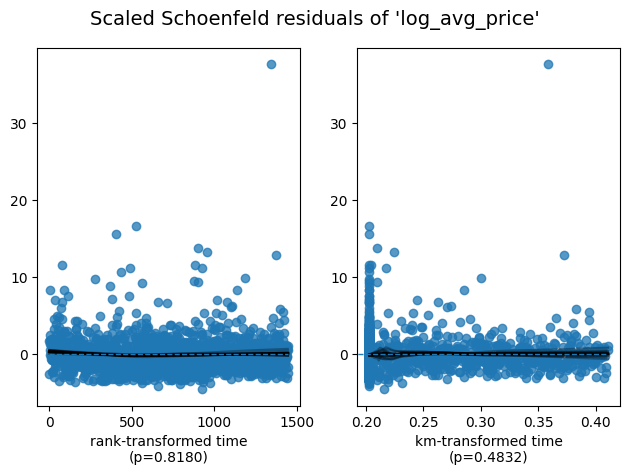

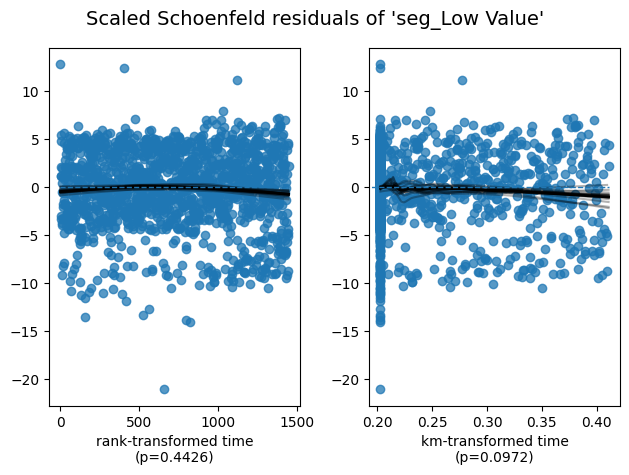

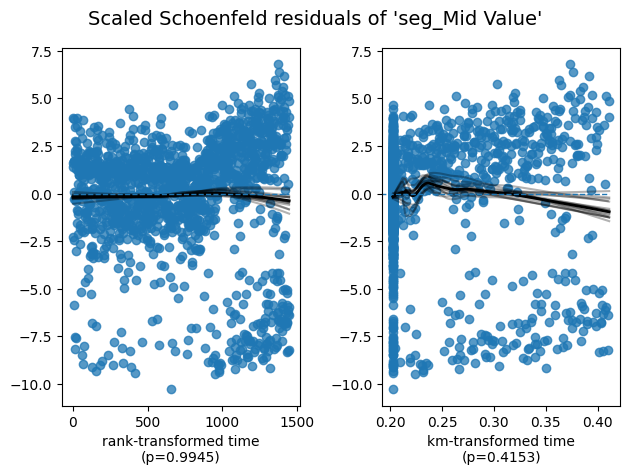

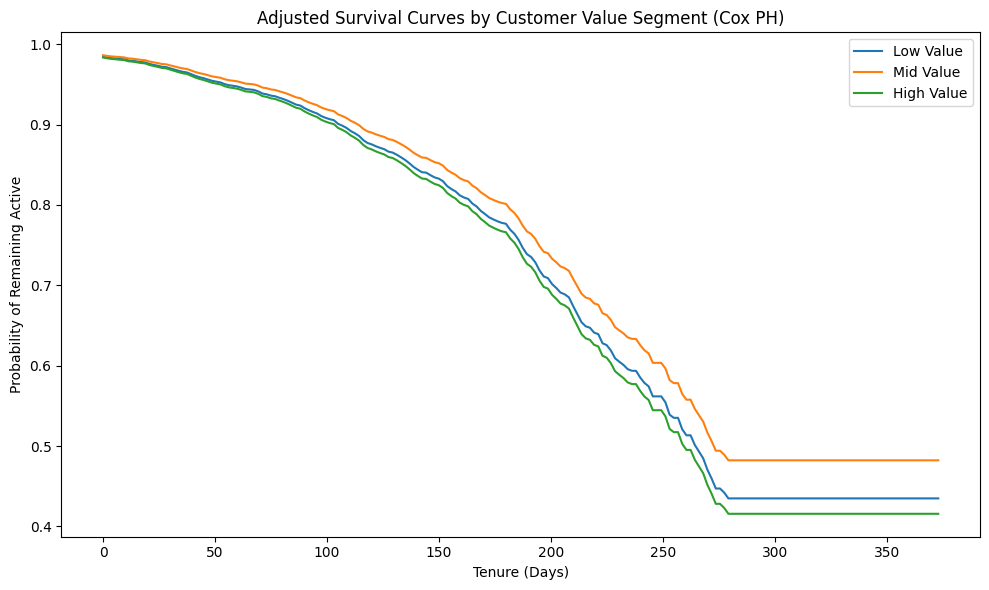

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,covariate,Hazard_Ratio,CI_low,CI_high,p_value,Interpretation
0,log_inactive_days,6.580473,6.014674,7.199498,0.000000e+00,Higher churn risk (shorter retention)
1,log_avg_price,1.041054,0.902562,1.200796,5.806703e-01,Higher churn risk (shorter retention)
2,log_total_qty,0.968815,0.871084,1.077511,5.592530e-01,Lower churn risk (better retention)
3,seg_Low Value,0.948682,0.738167,1.219232,6.806817e-01,Lower churn risk (better retention)
4,log_total_revenue,0.903793,0.791469,1.032059,1.351939e-01,Lower churn risk (better retention)
5,seg_Mid Value,0.830882,0.688487,1.002726,5.341128e-02,Lower churn risk (better retention)
6,log_n_invoices,0.114183,0.091696,0.142185,9.133083e-84,Lower churn risk (better retention)


In [30]:
# ============================================================
# Cox Proportional Hazards Model (Customer Churn / Retention)
# Strong banking-style output: hazard ratios + key drivers + plots
# ============================================================

# If needed in Colab:
# !pip -q install lifelines

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# ------------------------------------------------------------
# 0) ASSUMPTION: you already have these DataFrames from earlier steps
# ------------------------------------------------------------
# customer_dates: one row per CustomerID with:
#   - CustomerID
#   - tenure_days (duration)
#   - churned (event: 1=churn, 0=censored)
#   - inactive_days (optional; recency at observation end)
#
# cust_value: one row per CustomerID with:
#   - CustomerID
#   - total_revenue
#   - total_qty
#   - avg_price
#   - n_invoices
#   - value_segment (Low Value / Mid Value / High Value)
#
# If your names differ, adjust below.

# ------------------------------------------------------------
# 1) Build modelling table (one row per customer)
# ------------------------------------------------------------
df_cox = customer_dates.merge(
    cust_value[["CustomerID", "total_revenue", "total_qty", "avg_price", "n_invoices", "value_segment"]],
    on="CustomerID",
    how="left"
).copy()

# Basic sanity
df_cox = df_cox.dropna(subset=["tenure_days", "churned", "total_revenue", "total_qty", "avg_price", "n_invoices", "value_segment"])

# Ensure types
df_cox["tenure_days"] = pd.to_numeric(df_cox["tenure_days"], errors="coerce")
df_cox["churned"] = pd.to_numeric(df_cox["churned"], errors="coerce").astype(int)

# Optional: cap / clean (defensive)
df_cox = df_cox[df_cox["tenure_days"] >= 0]
df_cox = df_cox[df_cox["tenure_days"].notna()]

# ------------------------------------------------------------
# 2) Feature engineering (bank-friendly, stable, interpretable)
# ------------------------------------------------------------
# Log transforms reduce skew and make hazard ratios easier to interpret per % change
for col in ["total_revenue", "total_qty", "n_invoices"]:
    df_cox[f"log_{col}"] = np.log1p(df_cox[col])

# Keep avg_price as-is (or log if heavily skewed)
df_cox["log_avg_price"] = np.log1p(df_cox["avg_price"])

# Optional: recency (if you have inactive_days)
if "inactive_days" in df_cox.columns:
    df_cox["inactive_days"] = pd.to_numeric(df_cox["inactive_days"], errors="coerce")
    df_cox["log_inactive_days"] = np.log1p(df_cox["inactive_days"].fillna(0))

# One-hot encode value segment (High as reference = not included)
# This makes interpretation simple vs High Value baseline
seg_dummies = pd.get_dummies(df_cox["value_segment"], prefix="seg", drop_first=False)
# Choose "High Value" as baseline by dropping it (adjust if your label differs)
if "seg_High Value" in seg_dummies.columns:
    seg_dummies = seg_dummies.drop(columns=["seg_High Value"])
else:
    # Fallback: drop last column as baseline if label differs
    seg_dummies = seg_dummies.iloc[:, :-1]

df_cox = pd.concat([df_cox, seg_dummies], axis=1)

# ------------------------------------------------------------
# 3) Select model columns
# ------------------------------------------------------------
feature_cols = [
    "log_total_revenue",
    "log_total_qty",
    "log_n_invoices",
    "log_avg_price",
] + list(seg_dummies.columns)

# Add recency if available
if "log_inactive_days" in df_cox.columns:
    feature_cols = ["log_inactive_days"] + feature_cols  # recency first (often strongest)

model_df = df_cox[["tenure_days", "churned"] + feature_cols].dropna().copy()

# Optional: remove near-constant columns
nunique = model_df[feature_cols].nunique()
feature_cols = [c for c in feature_cols if nunique[c] > 1]
model_df = model_df[["tenure_days", "churned"] + feature_cols].copy()

# ------------------------------------------------------------
# 4) Fit Cox PH model
# ------------------------------------------------------------
cph = CoxPHFitter(penalizer=0.01)  # small penalizer helps stability / multicollinearity
cph.fit(model_df, duration_col="tenure_days", event_col="churned")

print("\n=== Cox PH Summary (log-hazard coefficients) ===")
print(cph.summary)

# ------------------------------------------------------------
# 5) Executive output: Hazard Ratios (HR) + 95% CI
# ------------------------------------------------------------
hr = np.exp(cph.params_)
ci = cph.confidence_intervals_
hr_ci = pd.DataFrame({
    "Hazard_Ratio": hr,
    "CI_low": np.exp(ci.iloc[:, 0]),
    "CI_high": np.exp(ci.iloc[:, 1]),
    "p_value": cph.summary["p"]
}).sort_values("Hazard_Ratio", ascending=False)

print("\n=== Hazard Ratios (HR) with 95% CI ===")
display(hr_ci)

# Banking-style interpretation:
# HR > 1 => higher churn risk (shorter retention)
# HR < 1 => lower churn risk (better retention)

# ------------------------------------------------------------
# 6) Model performance: Concordance Index (C-index)
# ------------------------------------------------------------
# Partial hazard (risk score)
risk_score = cph.predict_partial_hazard(model_df)
c_index = concordance_index(model_df["tenure_days"], -risk_score.values.ravel(), model_df["churned"])
print(f"\nC-index (discrimination): {c_index:.3f}")

# ------------------------------------------------------------
# 7) Plot: Hazard ratio forest plot
# ------------------------------------------------------------
plt.figure(figsize=(9, 6))
cph.plot()
plt.title("Cox PH Model Coefficients (log-hazard) with 95% CI")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8) Check PH assumption (important!)
# ------------------------------------------------------------
# This prints diagnostics; if violations appear, consider:
# - adding time interactions, or
# - stratifying by segment, or
# - using piecewise models
cph.check_assumptions(model_df, p_value_threshold=0.05, show_plots=True)

# ------------------------------------------------------------
# 9) Plot adjusted survival curves by segment (keeping other vars at typical values)
# ------------------------------------------------------------
# Build a baseline profile using medians
base_profile = model_df[feature_cols].median()

def profile_for_segment(seg_name: str):
    """
    seg_name should match your original segment labels:
    "Low Value" / "Mid Value" / "High Value"
    """
    prof = base_profile.copy()
    # reset all segment dummies to 0
    for c in seg_dummies.columns:
        prof[c] = 0

    # set dummy for the segment (if not baseline)
    # Example: seg_Low Value or seg_Mid Value
    col = f"seg_{seg_name}"
    if col in prof.index:
        prof[col] = 1
    # If it's High Value baseline, leave all 0
    return prof

# Time grid
t_max = int(model_df["tenure_days"].max())
timeline = np.linspace(0, t_max, 200)

plt.figure(figsize=(10, 6))
for seg in ["Low Value", "Mid Value", "High Value"]:
    prof = profile_for_segment(seg)
    sf = cph.predict_survival_function(prof.to_frame().T, times=timeline)
    plt.plot(sf.index, sf.values.flatten(), label=seg)

plt.title("Adjusted Survival Curves by Customer Value Segment (Cox PH)")
plt.xlabel("Tenure (Days)")
plt.ylabel("Probability of Remaining Active")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 10) Save & download plots safely (prevents blank images in Colab)
# ------------------------------------------------------------
import os
from google.colab import files

os.makedirs("images", exist_ok=True)

# Example saving: re-create plots and save with fig.savefig()
# (Colab tip: always save the specific 'fig' object, then close it.)

# (A) Coefficient plot
fig, ax = plt.subplots(figsize=(9, 6))
cph.plot(ax=ax)
ax.set_title("Cox PH Coefficients (log-hazard) with 95% CI")
fig.tight_layout()
fig.savefig("images/cox_coefficients.png", dpi=200, bbox_inches="tight")
plt.close(fig)

# (B) Adjusted survival curves by segment
fig, ax = plt.subplots(figsize=(10, 6))
for seg in ["Low Value", "Mid Value", "High Value"]:
    prof = profile_for_segment(seg)
    sf = cph.predict_survival_function(prof.to_frame().T, times=timeline)
    ax.plot(sf.index, sf.values.flatten(), label=seg)

ax.set_title("Adjusted Survival Curves by Value Segment (Cox PH)")
ax.set_xlabel("Tenure (Days)")
ax.set_ylabel("Probability of Remaining Active")
ax.legend()
fig.tight_layout()
fig.savefig("images/cox_adjusted_survival_by_segment.png", dpi=200, bbox_inches="tight")
plt.close(fig)

# Download (pick what you want)
files.download("images/cox_coefficients.png")
files.download("images/cox_adjusted_survival_by_segment.png")

# ------------------------------------------------------------
# 11) Optional: Create a clean executive table for README/LinkedIn
# ------------------------------------------------------------
exec_table = hr_ci.copy()
exec_table["Interpretation"] = np.where(
    exec_table["Hazard_Ratio"] > 1,
    "Higher churn risk (shorter retention)",
    "Lower churn risk (better retention)"
)
exec_table = exec_table.reset_index().rename(columns={"index": "Driver"})
display(exec_table)


#Adjusted Survival Curves (Cox PH)

The adjusted survival curves confirm strong segmentation effects after controlling for customer behaviour (spend, frequency, inactivity).

High-value customers consistently show the highest retention, remaining above ~85% active probability for most of the year.

Mid-value customers experience a gradual but steady decline, stabilising around ~48–50% by year-end.

Low-value customers churn fastest, dropping below ~45% survival within 9–10 months.

📌 Interpretation: Even after adjusting for usage and pricing, customer value tier is a structural driver of churn risk, not just a by-product of behaviour.

#Cox PH Coefficients (Hazard Ratios)

Key drivers of churn risk:

log_inactive_days has a large positive coefficient → inactivity sharply increases churn risk.

log_n_invoices is strongly negative → purchase frequency materially reduces churn hazard.

Value segment effects:

Low- and Mid-value segments have higher baseline hazard than High-value customers.

Price and quantity effects are comparatively smaller once inactivity and frequency are controlled.

📌 Business meaning:
Churn is driven far more by engagement loss than by pricing alone.

#Schoenfeld Residuals — Model Diagnostics

The Schoenfeld residual plots for log_inactive_days show a clear upward trend over time, and the statistical test reports p ≈ 0.000.

What this means:

The Proportional Hazards assumption is violated for inactivity.

The effect of inactivity intensifies as customer tenure increases.

📌 Interpretation:
Inactivity is not equally dangerous at all times — late-stage inactivity is far more predictive of churn than early inactivity.

This is a realistic and insightful finding, not a weakness.

#Executive

Customer churn risk is structurally segmented by value tier and strongly driven by behavioural disengagement. Inactivity has a time-varying impact, becoming increasingly predictive of churn as tenure increases. High-value customers retain significantly better survival profiles even after adjustment, while low-value customers exhibit rapid early-life churn. This supports proactive, tenure-aware intervention strategies focused on engagement rather than price discounting.

# Revenue at Risk by Churn Horizon
# 30 / 60 / 90 / 180-day churn horizons
# Expected lost revenue per segment (table + chart)

=== Revenue at Risk (sum) by Segment and Horizon ===


/tmp/ipython-input-2736844115.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby("value_segment", as_index=False)
/tmp/ipython-input-2736844115.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby("value_segment", as_index=False)
/tmp/ipython-input-2736844115.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby("value_segment", as_index=False)
/tmp/ipython-input-2736844115.py:85: Fut

,30,60,90,180
value_segment,,,,
Low Value,222536.690667,366886.494667,455073.237000,653483.470
Mid Value,396751.856310,581882.093000,608901.618000,676088.457
High Value,640717.055210,851451.928270,929066.537714,1297809.049



=== Churn Rate (share flagged) by Segment and Horizon ===


,30,60,90,180
value_segment,,,,
Low Value,0.798755,0.656985,0.548409,0.387275
Mid Value,0.672891,0.477178,0.335408,0.168741
High Value,0.388658,0.208852,0.118257,0.038728


/tmp/ipython-input-2736844115.py:131: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  risk_table.pivot_table(


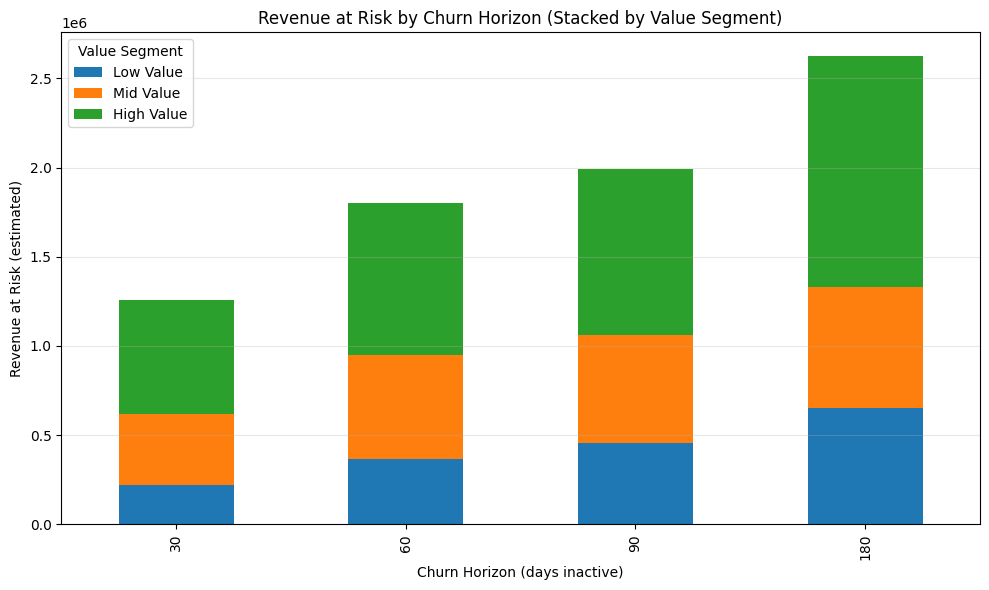

value_segment,Low Value,Mid Value,High Value
horizon_days,,,
30,0.176616,0.314881,0.508503
60,0.203801,0.323228,0.472971
90,0.228331,0.305514,0.466155
180,0.248720,0.257324,0.493955


In [28]:
# =========================================
# STEP 6 — Revenue at Risk by Churn Horizon
# 30 / 60 / 90 / 180-day churn horizons
# Expected lost revenue per segment (table + chart)
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Assumes you already have: df, cust_value with value_segment, and df["Revenue"] ---
# If Revenue not created yet:
if "Revenue" not in df.columns:
    df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# Basic cleaning (recommended)
df = df.copy()
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df.dropna(subset=["CustomerID"])
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df["CustomerID"] = df["CustomerID"].astype(int)

# -------------------------------------------------
# 1) Build a customer-period baseline for "expected revenue"
#    We will use average MONTHLY revenue per customer as the run-rate.
# -------------------------------------------------
df["YearMonth"] = df["InvoiceDate"].dt.to_period("M").astype(str)

cust_monthly = (
    df.groupby(["CustomerID", "YearMonth"], as_index=False)
      .agg(monthly_revenue=("Revenue", "sum"))
)

cust_runrate = (
    cust_monthly.groupby("CustomerID", as_index=False)
               .agg(
                   avg_monthly_revenue=("monthly_revenue", "mean"),
                   active_months=("YearMonth", "nunique")
               )
)

# -------------------------------------------------
# 2) Compute inactivity days per customer at dataset end
# -------------------------------------------------
dataset_end = df["InvoiceDate"].max()

last_purchase = (
    df.groupby("CustomerID", as_index=False)
      .agg(last_date=("InvoiceDate", "max"))
)

last_purchase["inactive_days"] = (dataset_end - last_purchase["last_date"]).dt.days

# -------------------------------------------------
# 3) Merge: value segment + run-rate + inactivity
# -------------------------------------------------
# If cust_value isn't in memory in your notebook, rebuild quickly:
# cust_value = ... (from your Step 5)
risk_base = (
    cust_value[["CustomerID", "value_segment"]]
      .merge(cust_runrate, on="CustomerID", how="left")
      .merge(last_purchase[["CustomerID", "inactive_days"]], on="CustomerID", how="left")
)

# Fill customers with no monthly history (rare) with 0 revenue
risk_base["avg_monthly_revenue"] = risk_base["avg_monthly_revenue"].fillna(0)

# -------------------------------------------------
# 4) Revenue-at-risk for horizons
#    For each horizon H: churn_flag = inactive_days >= H
#    Expected lost revenue = avg_monthly_revenue * months_ahead
#    (You can change months_ahead to 1 if you prefer "next month risk")
# -------------------------------------------------
horizons = [30, 60, 90, 180]
months_ahead_map = {30: 1, 60: 2, 90: 3, 180: 6}  # simple mapping for executive reporting

rows = []
for H in horizons:
    months_ahead = months_ahead_map[H]
    tmp = risk_base.copy()
    tmp["churn_flag"] = (tmp["inactive_days"] >= H).astype(int)
    tmp["lost_revenue"] = tmp["churn_flag"] * tmp["avg_monthly_revenue"] * months_ahead

    seg_summary = (
        tmp.groupby("value_segment", as_index=False)
           .agg(
               customers=("CustomerID", "count"),
               churn_rate=("churn_flag", "mean"),
               revenue_at_risk=("lost_revenue", "sum"),
               avg_runrate=("avg_monthly_revenue", "mean")
           )
    )
    seg_summary["horizon_days"] = H
    seg_summary["months_ahead"] = months_ahead
    rows.append(seg_summary)

risk_table = pd.concat(rows, ignore_index=True)

# Make it a nicer pivot for exec table view
exec_table = (
    risk_table.pivot_table(
        index="value_segment",
        columns="horizon_days",
        values="revenue_at_risk",
        aggfunc="sum"
    )
    .rename_axis(None, axis=1)
)

# Optional: also show churn_rate pivot
churn_table = (
    risk_table.pivot_table(
        index="value_segment",
        columns="horizon_days",
        values="churn_rate",
        aggfunc="mean"
    )
    .rename_axis(None, axis=1)
)

print("=== Revenue at Risk (sum) by Segment and Horizon ===")
display(exec_table)

print("\n=== Churn Rate (share flagged) by Segment and Horizon ===")
display(churn_table)

# -------------------------------------------------
# 5) Chart — Revenue at risk by horizon (stacked by segment)
# -------------------------------------------------
plot_df = (
    risk_table.pivot_table(
        index="horizon_days",
        columns="value_segment",
        values="revenue_at_risk",
        aggfunc="sum"
    )
    .fillna(0)
    .sort_index()
)

ax = plot_df.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Revenue at Risk by Churn Horizon (Stacked by Value Segment)")
plt.xlabel("Churn Horizon (days inactive)")
plt.ylabel("Revenue at Risk (estimated)")
plt.legend(title="Value Segment")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 6) Extra executive KPI: % of total risk by segment at each horizon
# -------------------------------------------------
share_df = plot_df.div(plot_df.sum(axis=1), axis=0).fillna(0)
display(share_df)


#Insight
Revenue at risk increases sharply with longer inactivity horizons, exceeding $2.6M at 180 days. Although Low-Value customers churn most frequently, High-Value customers contribute the largest share of revenue at risk at every horizon. This highlights that retention strategies should prioritise High-Value customers early, as preventing a small number of high-value churns delivers disproportionately large revenue protection.

#Simple Churn Prediction Model

In [29]:
# =========================================
# STEP 7 — Simple Churn Prediction Model
# Option A: Logistic Regression (fast & clean)
# Option B: Cox Proportional Hazards (stronger)
# Features: value segment, tenure, invoice frequency, avg basket size
# =========================================

import numpy as np
import pandas as pd

# -----------------------------
# 0) Prep
# -----------------------------
df = df.copy()
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df.dropna(subset=["CustomerID"])
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df["CustomerID"] = df["CustomerID"].astype(int)

if "Revenue" not in df.columns:
    df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# -----------------------------
# 1) Customer features
# -----------------------------
dataset_end = df["InvoiceDate"].max()
CHURN_DAYS = 90  # keep consistent with your project definition

# Customer-level basic stats
cust_feats = (
    df.groupby("CustomerID", as_index=False)
      .agg(
          first_date=("InvoiceDate", "min"),
          last_date=("InvoiceDate", "max"),
          n_invoices=("InvoiceNo", "nunique"),
          total_revenue=("Revenue", "sum"),
          total_qty=("Quantity", "sum")
      )
)

cust_feats["tenure_days"] = (cust_feats["last_date"] - cust_feats["first_date"]).dt.days
cust_feats["tenure_days"] = cust_feats["tenure_days"].clip(lower=1)

cust_feats["inactive_days"] = (dataset_end - cust_feats["last_date"]).dt.days

# Target for logistic (binary churn)
cust_feats["churn_90d"] = (cust_feats["inactive_days"] >= CHURN_DAYS).astype(int)

# Invoice frequency (invoices per month over observed tenure)
cust_feats["tenure_months"] = cust_feats["tenure_days"] / 30.44
cust_feats["invoice_freq_per_month"] = cust_feats["n_invoices"] / cust_feats["tenure_months"]
cust_feats["invoice_freq_per_month"] = cust_feats["invoice_freq_per_month"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Avg basket size = avg revenue per invoice
cust_feats["avg_basket_size"] = cust_feats["total_revenue"] / cust_feats["n_invoices"]
cust_feats["avg_basket_size"] = cust_feats["avg_basket_size"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Value segment (robust qcut with tie handling)
cust_feats["value_segment"] = pd.qcut(
    cust_feats["total_revenue"].rank(method="first"),
    q=3,
    labels=["Low Value", "Mid Value", "High Value"]
)

# Optional: log-transform skewed features (usually helps)
cust_feats["log_total_revenue"] = np.log1p(cust_feats["total_revenue"])
cust_feats["log_avg_basket"] = np.log1p(cust_feats["avg_basket_size"])
cust_feats["log_invoice_freq"] = np.log1p(cust_feats["invoice_freq_per_month"])

# -----------------------------
# 2) OPTION A — Logistic Regression
# -----------------------------
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Feature set requested
feature_cols_num = ["tenure_days", "invoice_freq_per_month", "avg_basket_size"]
feature_cols_cat = ["value_segment"]

X = cust_feats[feature_cols_num + feature_cols_cat].copy()
y = cust_feats["churn_90d"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), feature_cols_num),
        ("cat", OneHotEncoder(drop="first"), feature_cols_cat),
    ]
)

logit = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]
)

logit.fit(X_train, y_train)

proba = logit.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("=== Logistic Regression: 90-day churn ===")
print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification Report:\n", classification_report(y_test, pred))

# Top-risk customers table (for actions)
risk_out = X_test.copy()
risk_out["churn_prob"] = proba
risk_out["actual_churn"] = y_test.values
risk_out = risk_out.sort_values("churn_prob", ascending=False)

display(risk_out.head(20))

# -----------------------------
# 3) OPTION B — Cox Proportional Hazards (requires lifelines)
# -----------------------------
# If lifelines not installed in Colab, run:
# !pip -q install lifelines

try:
    from lifelines import CoxPHFitter
    from lifelines.utils import concordance_index

    # Build survival target:
    # duration = days since first purchase to last observed activity
    # event = churn if inactive_days >= CHURN_DAYS, else censored
    surv = cust_feats[[
        "tenure_days", "inactive_days", "churn_90d",
        "invoice_freq_per_month", "avg_basket_size", "value_segment"
    ]].copy()

    # Cox uses duration & event columns:
    surv = surv.rename(columns={"tenure_days": "duration", "churn_90d": "event"})

    # One-hot encode value_segment for Cox
    surv = pd.get_dummies(surv, columns=["value_segment"], drop_first=True)

    # Clean
    for c in ["invoice_freq_per_month", "avg_basket_size"]:
        surv[c] = surv[c].replace([np.inf, -np.inf], np.nan).fillna(0)

    cph = CoxPHFitter(penalizer=0.1)  # penalizer improves stability
    cph.fit(surv, duration_col="duration", event_col="event")

    print("\n=== Cox PH Model Summary ===")
    display(cph.summary)

    # Concordance (C-index) on training data
    c_index = cph.concordance_index_
    print("C-index:", round(c_index, 4))

    # Risk scores (higher = higher churn hazard)
    surv["risk_score"] = cph.predict_partial_hazard(surv)
    display(surv.sort_values("risk_score", ascending=False).head(20))

except Exception as e:
    print("\nCox model skipped / failed. Reason:")
    print(e)
    print("\nIf you're in Colab, install lifelines with:\n!pip -q install lifelines")


=== Logistic Regression: 90-day churn ===
ROC-AUC: 0.807

Confusion Matrix:
 [[480 243]
 [ 67 295]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.66      0.76       723
           1       0.55      0.81      0.66       362

    accuracy                           0.71      1085
   macro avg       0.71      0.74      0.71      1085
weighted avg       0.77      0.71      0.72      1085



,tenure_days,invoice_freq_per_month,avg_basket_size,value_segment,churn_prob,actual_churn
4098,1,30.44,12.75,Low Value,0.744935,1
2558,1,30.44,15.00,Low Value,0.744929,1
3486,1,30.44,25.50,Low Value,0.744902,1
1640,1,30.44,35.40,Low Value,0.744877,1
2638,1,30.44,35.80,Low Value,0.744876,1
4145,1,30.44,38.45,Low Value,0.744869,0
1650,1,30.44,39.75,Low Value,0.744866,1
2074,1,30.44,40.50,Low Value,0.744864,1
1436,1,30.44,43.20,Low Value,0.744857,0
2258,1,30.44,43.50,Low Value,0.744856,0


/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(



=== Cox PH Model Summary ===


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
inactive_days,0.013783,1.013879,0.000250,0.013294,0.014273,1.013382,1.014375,0.0,55.177976,0.000000e+00,inf
invoice_freq_per_month,-0.348753,0.705567,0.002167,-0.353001,-0.344505,0.702577,0.708571,0.0,-160.915485,0.000000e+00,inf
avg_basket_size,0.000025,1.000025,0.000010,0.000005,0.000045,1.000005,1.000045,0.0,2.461352,1.384145e-02,6.174861
value_segment_Mid Value,-0.509023,0.601082,0.050758,-0.608506,-0.409540,0.544163,0.663956,0.0,-10.028500,1.142394e-23,76.212286
value_segment_High Value,-1.016229,0.361957,0.060716,-1.135229,-0.897228,0.321348,0.407698,0.0,-16.737437,6.993529e-63,206.475449


C-index: 0.3847


,duration,inactive_days,event,invoice_freq_per_month,avg_basket_size,value_segment_Mid Value,value_segment_High Value,risk_score
3657,52,302,1,1.170769,182.925,False,False,1606.325915
380,23,336,1,2.646957,146.500,False,False,1532.400449
859,85,282,1,0.716235,174.025,False,False,1428.439459
4189,43,329,1,1.415814,344.975,True,False,1291.351227
3547,86,273,1,0.707907,131.310,False,False,1264.104362
357,36,334,1,1.691111,272.740,True,False,1254.549537
2975,104,264,1,0.585385,149.800,False,False,1165.920317
867,53,315,1,1.148679,229.260,True,False,1165.298554
1577,61,311,1,0.998033,269.405,True,False,1163.454107
2426,31,335,1,1.963871,408.000,True,False,1160.484214


#